In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt

In [2]:
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.transforms.v2 import Resize, ToTensor, Compose, Normalize

transforms =Compose([
    ToTensor(),
    Resize((56, 56)),
    Normalize(mean=(0,), std=(1,))
])

train_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms,
)

test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms,
)

class_names = train_data.classes

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.94MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

# NiN construction

In [4]:
class NiN(nn.Module):
    def __init__(self, in_channels=1, out_shape=10, activation_fn=nn.GELU):
        super().__init__()
        
        self.activation_fn = activation_fn 
        
        self.net = nn.Sequential(
            self.nin_block(in_channels, 96, 5, 0),
            nn.MaxPool2d(3, stride=2),
            self.nin_block(96, 256, 3, 2),
            nn.MaxPool2d(3, stride=2),
            self.nin_block(256, 384, 3),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            self.nin_block(384, out_shape, 3),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
            
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')

    def nin_block(self, in_channels, out_channels, kernel_size, padding=1):
        return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size), self.activation_fn(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), self.activation_fn(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), self.activation_fn())
        
    def forward(self, x):
        x = self.net(x)

        return x

In [5]:
#img = train_data[0][0].unsqueeze(dim=0)
#model_test = NiN()
#model_test(img)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
def train_step(model, train_dataloader, loss_fn, accuracy_fn, optimizer, device="cpu"):
    model.to(device)
    model.train()
    train_loss = train_acc = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X)

        loss = loss_fn(y_logits, y)

        train_loss += loss
        train_acc += accuracy_fn(y_logits.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss.detach().cpu().item(), train_acc


def test_step(model, train_dataloader, loss_fn, accuracy_fn, device="cpu"):
    model.to(device)
    model.eval()
    test_loss = test_acc = 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_logits = model(X)
        
            test_loss += loss_fn(y_logits, y)
            test_acc += accuracy_fn(y_logits.argmax(dim=1), y)
    
    
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
        return test_loss.detach().cpu().item(), test_acc

In [8]:
def accuracy_fn(y_pred, y_true):
    return torch.eq(y_pred, y_true).sum().item() / len(y_true)

## Training

In [9]:
from tqdm.auto import tqdm

model_0 = NiN()

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_0.parameters(), lr=0.01, momentum=0.9, nesterov=True)

epoches = 11

train_losses_0 = []
test_losses_0 = []
test_acc_0 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_0, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_0, test_dataloader, loss_fn, accuracy_fn, device)

    if epoche % 2 == 0:
        print(f"\nEpoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_0.append(train_info[0])
    test_losses_0.append(test_info[0])
    test_acc_0.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]


Epoche: 0
---------
Train loss: 1.39259 | Train accuracy: 0.48%
Test loss: 0.58608 | Test accuracy: 0.77%

Epoche: 2
---------
Train loss: 0.43368 | Train accuracy: 0.84%
Test loss: 0.39063 | Test accuracy: 0.86%

Epoche: 4
---------
Train loss: 0.35072 | Train accuracy: 0.87%
Test loss: 0.34550 | Test accuracy: 0.87%

Epoche: 6
---------
Train loss: 0.30980 | Train accuracy: 0.89%
Test loss: 0.31696 | Test accuracy: 0.88%

Epoche: 8
---------
Train loss: 0.28014 | Train accuracy: 0.90%
Test loss: 0.30678 | Test accuracy: 0.89%

Epoche: 10
---------
Train loss: 0.25432 | Train accuracy: 0.91%
Test loss: 0.28210 | Test accuracy: 0.90%


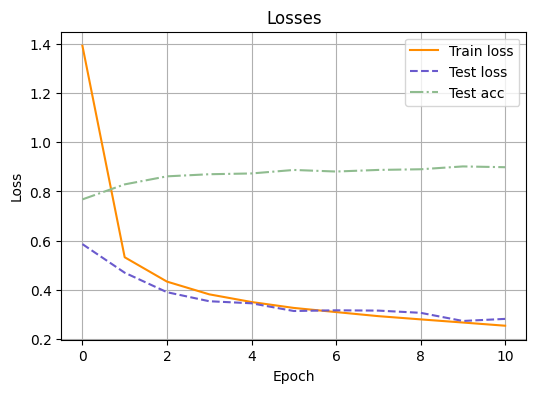

In [10]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), train_losses_0, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_0, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_0, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Losses")
plt.legend()
plt.grid(True)
plt.show()

# Summary

In [11]:
from torchinfo import summary


summary(model_0, input_size=(1, 1, 56, 56))

Layer (type:depth-idx)                   Output Shape              Param #
NiN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 96, 52, 52]           --
│    │    └─Conv2d: 3-1                  [1, 96, 52, 52]           2,496
│    │    └─GELU: 3-2                    [1, 96, 52, 52]           --
│    │    └─Conv2d: 3-3                  [1, 96, 52, 52]           9,312
│    │    └─GELU: 3-4                    [1, 96, 52, 52]           --
│    │    └─Conv2d: 3-5                  [1, 96, 52, 52]           9,312
│    │    └─GELU: 3-6                    [1, 96, 52, 52]           --
│    └─MaxPool2d: 2-2                    [1, 96, 25, 25]           --
│    └─Sequential: 2-3                   [1, 256, 23, 23]          --
│    │    └─Conv2d: 3-7                  [1, 256, 23, 23]          221,440
│    │    └─GELU: 3-8                    [1, 256, 23, 23]          --
│

**Как вывод: совокупная сложность архитектуры NiN в $10-10^2$ меньше, чем у моделей архитектуры VGG**